In [1]:
import numpy as np
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('using device:', device)

using device: cuda


In [2]:
import os
from typing import Tuple


def load_dataset(path: os.PathLike, device: torch.device = 'cpu'
                 ) -> Tuple[torch.Tensor, torch.Tensor]:
    X = np.load(os.path.join(path, 'inputs.npy'))
    T = np.load(os.path.join(path, 'targets.npy'))

    N = X.shape[0]
    X = X.reshape((N, 1, 256, 256)) # reshape to 1-channel for convolutions

    return torch.tensor(X, device=device, dtype=torch.float32), \
        torch.tensor(T, device=device, dtype=torch.long)

# X_train = torch.tensor(X, device=device, dtype=torch.float32)
# y_train = torch.tensor(T, device=device, dtype=torch.long)
X_train, y_train = load_dataset('model_train/train', device)

n_classes = int(y_train.max()) + 1
X_train.shape, y_train.shape, n_classes

(torch.Size([8606, 1, 256, 256]), torch.Size([8606]), 232)

In [3]:
from ipynb.fs.defs.model import create_model
from torch.nn import CrossEntropyLoss
from torch.optim import AdamW

model = create_model(n_classes, device)

optim = AdamW(model.parameters(), lr=1e-5)
loss_fn = CrossEntropyLoss()

In [4]:
o = model(X_train[:1])
loss_fn(o, y_train[:1])

tensor(5.4467, device='cuda:0', grad_fn=<NllLossBackward0>)

In [5]:
epochs     = 200
batch_size = 64

In [6]:
from ipynb.fs.defs.model import train

t_l, v_l = train(model, epochs, X_train, y_train, optim, loss_fn, bs=batch_size)

Starting training.
Number of minibatches for training/test: 118/17
Starting epoch 1 of 200
	Training took: 72.20s	with loss: 5.399927
Starting epoch 2 of 200
	Training took: 71.97s	with loss: 5.399597
Starting epoch 3 of 200
	Training took: 71.90s	with loss: 5.399596
Starting epoch 4 of 200
	Training took: 73.71s	with loss: 5.399597
Starting epoch 5 of 200
	Training took: 72.18s	with loss: 5.399597
Starting epoch 6 of 200
	Training took: 71.75s	with loss: 5.399598
Starting epoch 7 of 200
	Training took: 71.79s	with loss: 5.399598
Starting epoch 8 of 200
	Training took: 71.89s	with loss: 5.399597
Starting epoch 9 of 200


KeyboardInterrupt: 

In [6]:
np.save('train_losses_new.npy', t_l)
np.save('valid_losses_new.npy', v_l)

In [9]:
t_l = []
v_l = []

ckpt_path = 'checkpoints/11-06-2024-11-35-39'

for f in os.listdir(ckpt_path):
    if not f.endswith('.pt'):
        continue
    ckpt = torch.load(os.path.join(ckpt_path, f))
    t_l.append(ckpt['train_loss'])
    v_l.append(ckpt['valid_loss'])

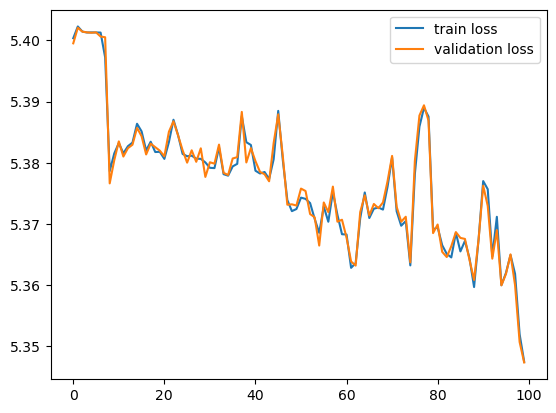

In [6]:
import matplotlib.pyplot as plt

n = len(t_l)

ax = plt.subplot()
ax.plot(np.arange(n), t_l, label='train loss')
ax.plot(np.arange(n), v_l, label='validation loss')
plt.legend()

In [13]:
from ipynb.fs.defs.model import eval_acc, load_model_checkpoint

accs = [0] * 100
test_accs  = [0] * 100

ckpt_path = 'checkpoints/13-06-2024-11-03-08'

X_test, y_test = load_dataset('model_train/test', device=device)

model.eval()
for f in os.listdir(ckpt_path):
    if not f.endswith('.pt'):
        continue
    model_file = os.path.join(ckpt_path, f)
    ckpt = load_model_checkpoint(model_file, model, device=device)
    e = ckpt['epoch']
    # ckpt = torch.load(model_file, map_location='cuda')
    tr_acc = eval_acc(model, X_train, y_train, bs=batch_size)
    te_acc = eval_acc(model, X_test, y_test, bs=batch_size)
    accs[e] = tr_acc
    test_accs[e] = te_acc

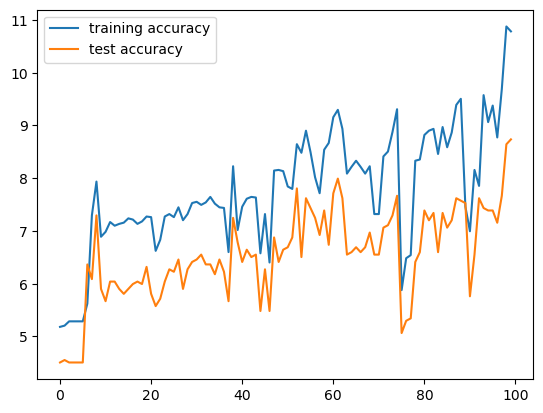

In [15]:
import matplotlib.pyplot as plt

np_accs = np.array(accs) * 100
np_test_accs = np.array(test_accs) * 100

ax = plt.subplot()
ax.plot(np.arange(len(accs)), np_accs, label='training accuracy')
ax.plot(np.arange(len(accs)), np_test_accs, label='test accuracy')
plt.legend()